## Import and initialisation

In [63]:
# Import
import math
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, BooleanType, DoubleType
from pyspark.sql.functions import col

In [ ]:
# Spark cluster init
def bytes_to_mb(size_bytes):
    """Converts bytes to megabytes."""
    return size_bytes / (1024 * 1024)

def bytes_to_gb(size_bytes):
    """Converts bytes to gigabytes."""
    return size_bytes / (1024 * 1024 * 1024)

def configure_spark(dataset_size_gb):
    """Configures Spark based on dataset size.

    Args:
        dataset_size_gb (float): Size of the dataset in gigabytes.

    Returns:
        tuple: Executor cores and memory configuration.
    """

    core_factor   = 2
    memory_factor = 1
    executor_cores  = int(dataset_size_gb * core_factor) + 2
    executor_memory = f"{min(executor_cores, 4) * memory_factor}g"
  
    return executor_cores, executor_memory


def build_spark_session(hdfs_path, file_path, verbose=False):
    """Builds a Spark session and retrieves file size from HDFS.

    Args:
        hdfs_path (str): HDFS path.
        file_path (str): File path within HDFS.
        verbose (bool, optional): Enable verbose output. Defaults to False.

    Returns:
        tuple: SparkSession, SparkContext, and file size.
    """
    spark = SparkSession.builder.appName("Project Group 32 HDFSFileSize").getOrCreate()
    jvm = spark._jvm
    conf = jvm.org.apache.hadoop.conf.Configuration()
    fs = jvm.org.apache.hadoop.fs.FileSystem.get(jvm.java.net.URI.create(hdfs_path), conf)
    path = jvm.org.apache.hadoop.fs.Path(file_path)
    fileStatus = fs.getFileStatus(path)
    fileSize = fileStatus.getLen()

    if verbose:
        print(f"File size in bytes: {fileSize}")

    spark.stop()

    executor_cores, executor_memory = configure_spark(bytes_to_gb(fileSize))

    spark_session = SparkSession.builder\
            .master("spark://192.168.2.156:7077") \
            .appName("Project Group 32")\
            .config("spark.dynamicAllocation.enabled", True)\
            .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
            .config("spark.shuffle.service.enabled", False)\
            .config("spark.dynamicAllocation.executorIdleTimeout","60s")\
            .config("spark.executor.cores", min(executor_cores, 4))\
            .config("spark.executor.memory", executor_memory)\
            .config("spark.cores.max", min(executor_cores, 32))\
            .config("spark.driver.port",9999)\
            .config("spark.blockManager.port",10005)\
            .getOrCreate()

    # RDD API
    spark_context = spark_session.sparkContext
    spark_context.setLogLevel("ERROR")

    if verbose:
        print(f"A files size of {bytes_to_gb(fileSize):.4f} GB give a maximum \n"+
              f"of {spark_session.conf.get('spark.cores.max')} cores divided on spark executors with:\n"+
            f"Executor cores: {spark_session.conf.get('spark.executor.cores')}\n"+
            f"Executor memory: {spark_session.conf.get('spark.executor.memory')}\n"+
            f"Mem/core: {int(spark_session.conf.get('spark.executor.memory')[:-1])/int(spark_session.conf.get('spark.executor.cores')):.0f}GB")

    return spark_session, spark_context, fileSize

## Load the data

First we start with loading all the data from the smallest dataset. We take a look at the structure and some samples. 

In [65]:
hdfs_path = "hdfs://192.168.2.156:9000"
file_path = "/data/reddit/reddit_50k.json"
verbose   = True
spark_session, spark_context, fileSize = build_spark_session(hdfs_path, file_path, verbose=verbose)

File size in bytes: 392090252
A files size of 0.3652 GB give a maximum 
of 2 cores divided on spark executors with:
Executor cores: 2
Executor memory: 2g
Mem/core: 1GB


In [66]:
df = spark_session.read.json(hdfs_path + file_path)
# Show schema to understand the structure
print("The schema:")
df.printSchema()
print("\n")

# Count total number of rows
print(f"Total Rows: {df.count()}")

# Show first few rows to inspect data
print("The first 10 entries in the dataframe:")
df.show(10, truncate=False)
print("\n")


The schema:
root
 |-- _corrupt_record: string (nullable = true)
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- content: string (nullable = true)
 |-- content_len: long (nullable = true)
 |-- id: string (nullable = true)
 |-- normalizedBody: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- summary_len: long (nullable = true)
 |-- title: string (nullable = true)





Total Rows: 99999
The first 10 entries in the dataframe:
+---------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [67]:
spark_context.stop()

We can observe that every other row appears to be 'null' row and can therefore be removed for the full preprocessing.


Now we move onto load the 'subreddit' column of the full dataset to determine how it is distributed. Since we want to predict which subreddit a post belongs to we check how much data there is for the different subreddits and determine if we can keep them all or only use a subset of them. 

In [68]:
hdfs_path = "hdfs://192.168.2.156:9000"
file_path = "/data/reddit/corpus-webis-tldr-17.json"
verbose   = True
spark_session, spark_context, fileSize = build_spark_session(hdfs_path, file_path, verbose=verbose)

subreddit_field = StructField(name="subreddit", dataType=StringType(), nullable=True)
schema_v0 = StructType([subreddit_field])

File size in bytes: 19620286497
A files size of 18.2728 GB give a maximum 
of 32 cores divided on spark executors with:
Executor cores: 4
Executor memory: 4g
Mem/core: 1GB


Again we remove any null entries and since we are interested in the number of samples for each subreddit we group by on subreddit with aggregation count.

In [69]:
df = spark_session.read.json(hdfs_path + file_path, schema=schema_v0)
df_filtered = df.filter(col("subreddit").isNotNull())
df_filtered = df_filtered.groupBy("subreddit").count().orderBy(col("count").desc())

To work with the file locally we convert it to a pandas dataframe. The stop the spark context since it is not needed anymore.

In [70]:
pandas_df = df_filtered.toPandas()


In [71]:
spark_context.stop()

Write the frame to csv for external processing

In [72]:
# NOTE! Uncomment the lines below and specify the output path
#out_path  = "/home/ubuntu/out/" 
#pandas_df.to_csv(f"{out_path}subreddit_data.csv", header=True)

Now we continue to explore and visualise the information in the dataframe.

In [73]:
pandas_df.sort_values(["count"], inplace=True, ascending=False)
pandas_df.reset_index(drop=True, inplace=True)
print(pandas_df.shape)
print(pandas_df.columns)
print(pandas_df[:5])

(29650, 2)
Index(['subreddit', 'count'], dtype='object')
             subreddit   count
0            AskReddit  589947
1        relationships  352049
2      leagueoflegends  109307
3                 tifu   52219
4  relationship_advice   50416


The subreddits are now sorted on their count in descending order and the index is the order in which they appear in the list. When plotting we will have the index on the x-axis and the count on the y-axis.

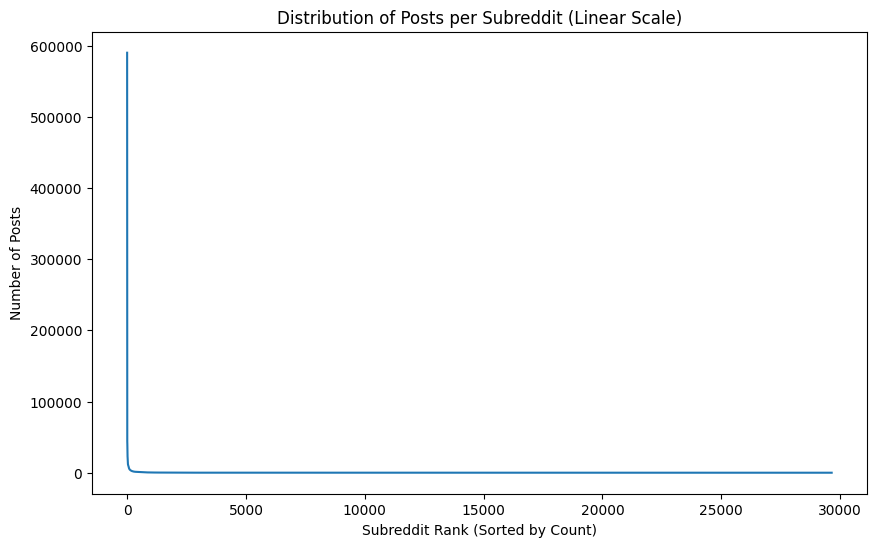

In [74]:
plt.figure(figsize=(10, 6))  # Adjust figure size for better viewing
plt.plot(pandas_df["count"])
plt.title("Distribution of Posts per Subreddit (Linear Scale)")
plt.xlabel("Subreddit Rank (Sorted by Count)")
plt.ylabel("Number of Posts")
plt.show()

From the graph we can see that there is far from an even distribution on the number of posts for each subreddit. It looks like that almost all posts belong to the very first (very small) n subreddits. To gain more intuition on the distirbution we look at a logarithmic scale instead.

Text(0, 0.5, 'Number of Posts (Log Scale)')

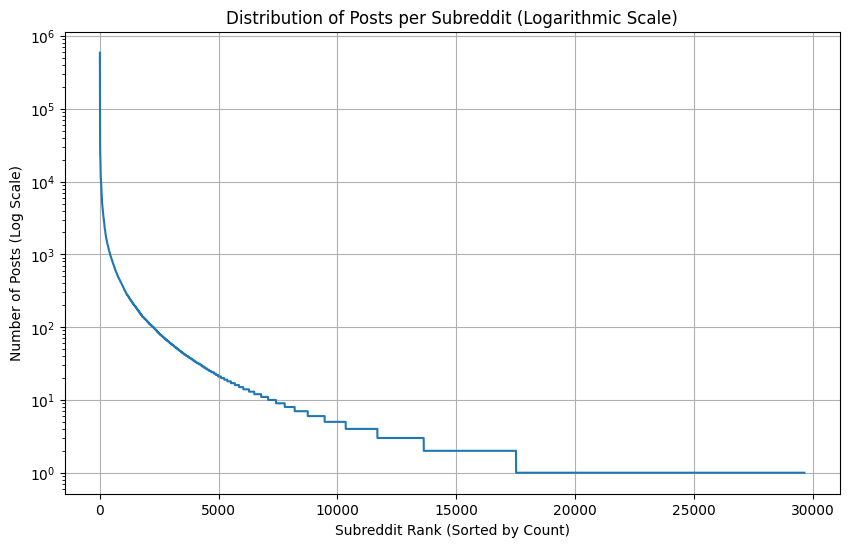

In [75]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.grid(True)
plt.plot(pandas_df["count"])
plt.title("Distribution of Posts per Subreddit (Logarithmic Scale)")
plt.xlabel("Subreddit Rank (Sorted by Count)")
plt.ylabel("Number of Posts (Log Scale)")

Now we can see that there is a very large skew even in the first ~100 subreddits and that ~17500 subreddits only have one occurence each. We expand the top 50 on a logarithmic scale to try to determine a breaking point for how many subreddits are viable for the machine learning algorithm.

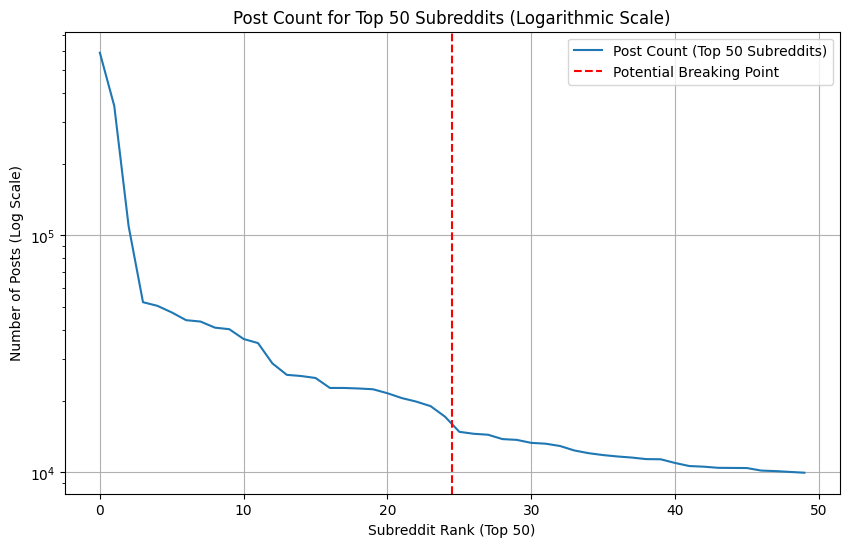

In [76]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.grid(True)
plt.plot(pandas_df["count"][:50], label="Post Count (Top 50 Subreddits)")
plt.axvline(x=24.5, color='r', linestyle='--', label="Potential Breaking Point")
plt.title("Post Count for Top 50 Subreddits (Logarithmic Scale)")
plt.xlabel("Subreddit Rank (Top 50)")
plt.ylabel("Number of Posts (Log Scale)")
plt.legend()
plt.show()

There is some sort of gap between indexes 24 and 25 as marked by the red line. Given that the ML needs sufficient data from each subreddit to train, the top 25 subreddits seems to be a viable option to use. For fun, we can print the top 50 to see what subreddits are overrepresented in the dataset.

In [77]:
print(pandas_df.head(50))

               subreddit   count
0              AskReddit  589947
1          relationships  352049
2        leagueoflegends  109307
3                   tifu   52219
4    relationship_advice   50416
5                  trees   47286
6                 gaming   43851
7                atheism   43268
8          AdviceAnimals   40783
9                  funny   40171
10              politics   36518
11                  pics   35098
12                   sex   28806
13                   WTF   25781
14     explainlikeimfive   25482
15         todayilearned   25004
16               Fitness   22694
17                  IAmA   22689
18             worldnews   22577
19                 DotA2   22405
20       TwoXChromosomes   21562
21                videos   20567
22        DestinyTheGame   19878
23            reddit.com   19020
24            offmychest   17175
25              buildapc   14817
26                AskMen   14538
27       personalfinance   14403
28        summonerschool   13806
29        